# Trading System Using RSI as a Long Trend Indicator
## By Ori Rosenthal

In [1]:
import talib
import pandas as pd
import numpy as np
from cmc import coinmarketcap
import matplotlib.pyplot as plt
%matplotlib inline


start = pd.to_datetime('2016-01-01')
end = pd.datetime.now() 
df = coinmarketcap.getDataFor('bitcoin', start, end, fields = ['Close'])
df.columns = df.columns.droplevel(level=0)
df.head().round()

100%|████████████████████████████████████████████| 1/1 [00:02<00:00,  2.31s/it]


,Close
Date,
2016-01-01,434.0
2016-01-02,433.0
2016-01-03,430.0
2016-01-04,433.0
2016-01-05,432.0


In [2]:
df['RSI'] = talib.RSI(np.array(df.Close),35).round(2)
df.tail().round()

,Close,RSI
Date,,
2019-01-08,4031.0,45.0
2019-01-09,4035.0,45.0
2019-01-10,3679.0,42.0
2019-01-11,3687.0,42.0
2019-01-12,3661.0,41.0


In [3]:
df.isnull().sum()

Close     0
RSI      35
dtype: int64

In [4]:
df.dropna(inplace=True)

In [5]:
def figR (df, stime, etime):
    fig = plt.figure(facecolor='white', figsize=(16,10))
    axescolor = '#f6f6f6'  

    plt.rc('axes', grid=True)
    plt.rc('grid', color='0.75', linestyle='-', linewidth=0.5)

    textsize = 15
    left, width = 0.1, 0.8
    rect1 = [left, 0.9, width, 0.2]
    rect2 = [left, 0.4, width, 0.5]

    ax1 = fig.add_axes(rect1, facecolor=axescolor) 
    ax2 = fig.add_axes(rect2, facecolor=axescolor, sharex=ax1)
    ax2t = ax2.twinx()

    prices = df.loc[stime:etime]['Close']
    rsi = df.loc[stime:etime]['RSI']
    fillcolor = 'b'

    ax1.plot(df.loc[stime:etime].index, rsi, color=fillcolor)
    ax1.axhline(55, color='g')
    ax1.axhline(45, color='r')
    ax1.text(0.6, 0.9, '>55 = Long', va='top', transform=ax1.transAxes, fontsize=textsize)
    ax1.text(0.6, 0.1, '<45 = Short', transform=ax1.transAxes, fontsize=textsize)
    ax1.set_ylim(20, 80)
    ax1.set_yticks([45, 55])
    ax1.set_xlim(stime,etime)
    ax1.text(0.01, 0.95, 'RSI (35)', va='top', transform=ax1.transAxes, fontsize=textsize)
    ax1.set_title('Bitcoin daily', fontsize=textsize)
    ax2.plot(prices , color='black', label='_nolegend_')
    return figR

<function __main__.figR>

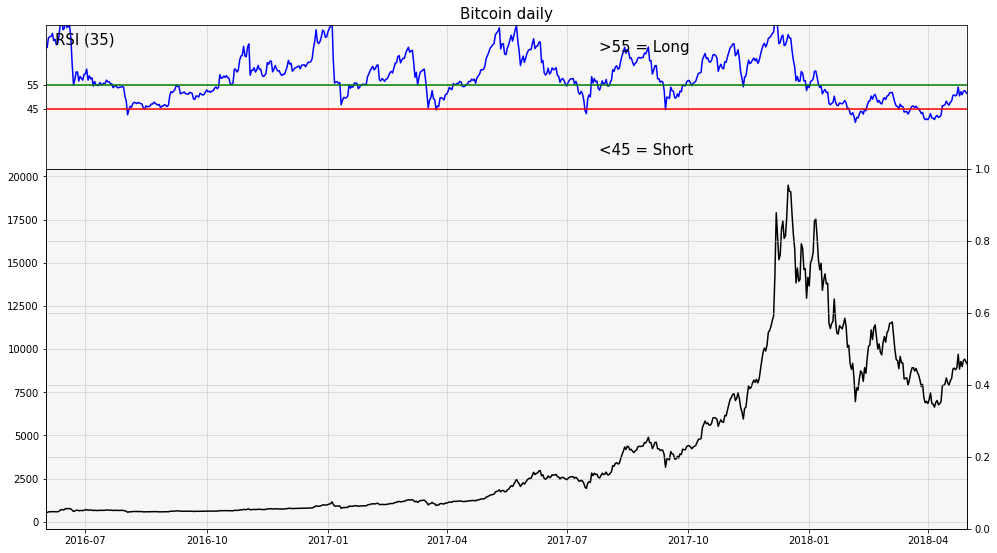

In [6]:
figR(df,'2016-06-01','2018-05-01')

<function __main__.figR>

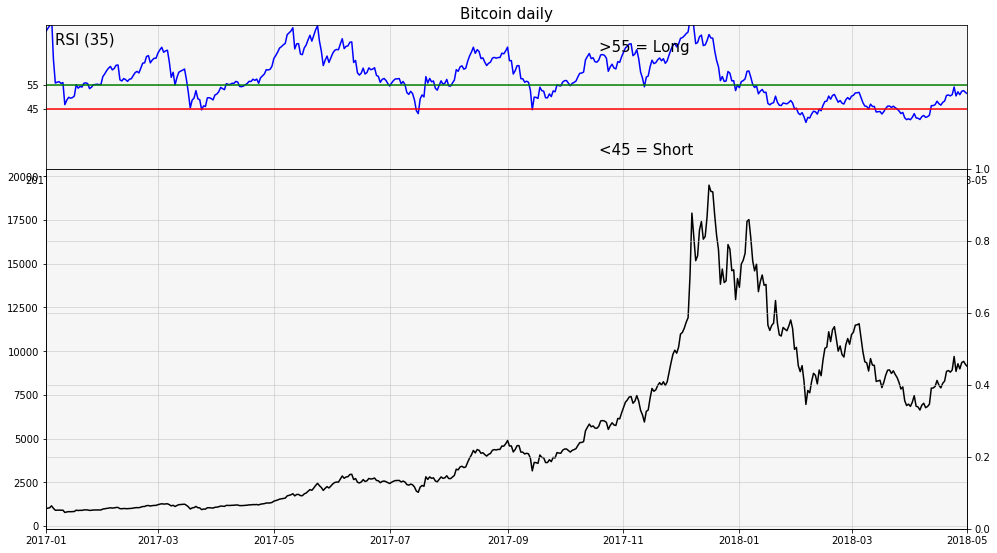

In [7]:
figR(df,'2017-01-01','2018-05-01')

<function __main__.figR>

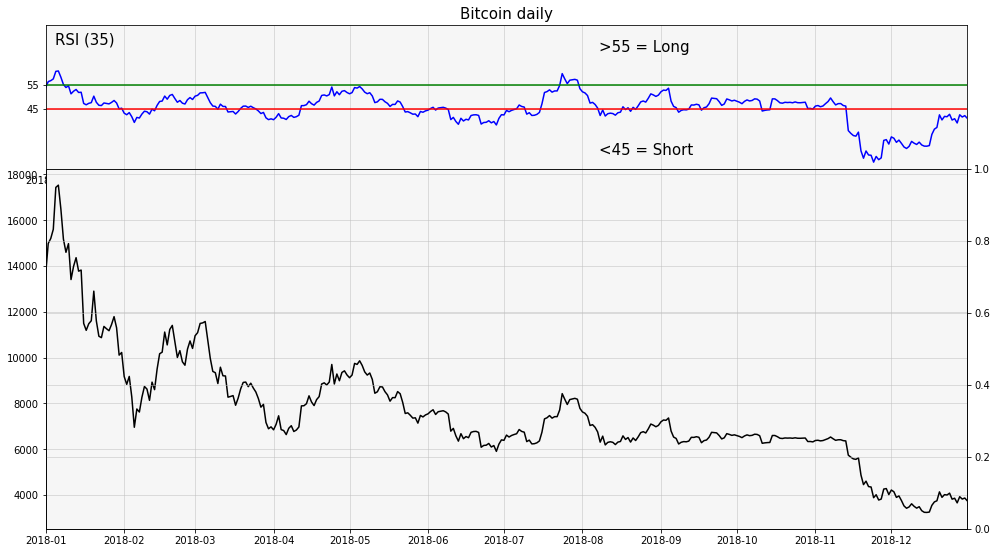

In [8]:
figR(df,'2018-01-01','2018-12-31')

# Creating Trading System 
## Rules: Long when RSI > 55, exit long under 50, Short when RSI < 45, exit short above 50


In [9]:
df['RSI'] = df['RSI'].shift(1)

In [10]:
# Trade Entry
df['long_entry'] = df.RSI > 55
df['short_entry'] = df.RSI < 45

In [11]:
# Trade Exit
df['long_exit'] = df.RSI < 50
df['short_exit'] = df.RSI > 50

In [12]:
df['Position_Long'] = np.nan
df.loc[df.long_entry,'Position_Long'] = 1
df.loc[df.long_exit,'Position_Long'] = 0

In [13]:
df['Position_Short'] = np.nan
df.loc[df.short_entry,'Position_Short'] = -1
df.loc[df.short_exit,'Position_Short'] = 0

In [14]:
df = df.fillna(method='ffill')
df['Signal'] = df.Position_Long + df.Position_Short
df.dropna(inplace=True)
df['SignalDiff'] = df['Signal'].diff()

In [15]:
df['daily_Bitcoin_returns'] = np.log(df.Close/df.Close.shift(1))
df['daily_strategy_returns'] = df['daily_Bitcoin_returns'] * df.Signal.shift(1)

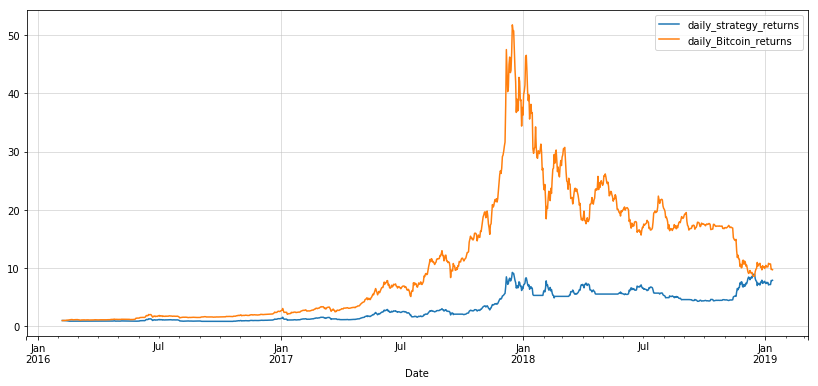

In [16]:
df[['daily_strategy_returns','daily_Bitcoin_returns']].dropna().cumsum().apply(np.exp).plot(figsize=(14,6));

In [17]:
df.daily_strategy_returns.dropna().cumsum().apply(np.exp)[-1]

7.911276559941362

In [18]:
cagr = np.exp(np.log1p(df['daily_strategy_returns']).cumsum())[-1] ** (1/(len(df)/252))-1
print ('Strategy had a CAGR of {:.2%} '.format(cagr))

Strategy had a CAGR of 36.76% 


## Sharpe Ratio

In [19]:
returns = df['daily_strategy_returns'][df['daily_strategy_returns'] !=0]
sharpe = np.sqrt(252) * (np.mean(returns) / np.std(returns)) 
print ('Strategy had a sharpe ratio of {:.2} '.format(sharpe))

Strategy had a sharpe ratio of 0.94 


## Drawdown & Drawdown Duration


In [20]:
cr = df['daily_strategy_returns'].cumsum()
highwatermark = [0]

idx = df.index
drawdown = pd.Series(index = idx)
Dduration = pd.Series(index = idx)
    
for t in range(1, len(idx)) :
    highwatermark.append(max(highwatermark[t-1], cr [t]))
    drawdown[t]= (highwatermark[t]-cr [t])
    Dduration[t]= (0 if drawdown[t] == 0 else Dduration[t-1]+1)

print ('Max Drawdown: -{:.2%} '.format(drawdown.max()))
print ('Drawdown Duration {} days '.format(int(Dduration.max())))

Max Drawdown: -76.75% 
Drawdown Duration 392 days 


## Compound Annual Growth Rate - CAGR


In [21]:
days = (df.index[-1] - df.index[0]).days
cagr = ((((5.8738054321299078) /1)) ** (365.0/days)) - 1
print ('CAGR =',str(round(cagr,4)*100)+"%")

CAGR = 82.83%
